In [2]:
import numpy as np
import matplotlib.pyplot as plt


def createGabor( sigma, theta, lamda, psi, gamma ):
#CREATEGABOR Creates a complex valued Gabor filter.
#   myGabor = createGabor( sigma, theta, lamda, psi, gamma ) generates
#   Gabor kernels.  
#   - ARGUMENTS
#     sigma      Standard deviation of Gaussian envelope.
#     theta      Orientation of the Gaussian envelope. Takes arguments in
#                the range [0, pi/2).
#     lamda     The wavelength for the carriers. The central frequency 
#                (w_c) of the carrier signals.
#     psi        Phase offset for the carrier signal, sin(w_c . t + psi).
#     gamma      Controls the aspect ratio of the Gaussian envelope
#   
#   - OUTPUT
#     myGabor    A matrix of size [h,w,2], holding the real and imaginary 
#                parts of the Gabor in myGabor(:,:,1) and myGabor(:,:,2),
#                respectively.
                
    # Set the aspect ratio.
    sigma_x = sigma
    sigma_y = float(sigma)/gamma

    # Generate a grid
    nstds = 3
    xmax = max(abs(nstds*sigma_x*np.cos(theta)),abs(nstds*sigma_y*np.sin(theta)))
    xmax = np.ceil(max(1,xmax))
    ymax = max(abs(nstds*sigma_x*np.sin(theta)),abs(nstds*sigma_y*np.cos(theta)))
    ymax = np.ceil(max(1,ymax))

    # Make sure that we get square filters. 
    xmax = max(xmax,ymax)
    ymax = max(xmax,ymax)
    xmin = -xmax 
    ymin = -ymax

    # Generate a coordinate system in the range [xmin,xmax] and [ymin, ymax]. 
    [x,y] = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))

    # Convert to a 2-by-N matrix where N is the number of pixels in the kernel.
    XY = np.concatenate((x.reshape(1, -1), y.reshape(1, -1)), axis=0)

    # Compute the rotation of pixels by theta.
    # \\ Hint: Create appropriate rotation matrix to compute the rotated pixel coordinates: rot(theta) * XY.
    cs, sn = np.cos(theta), np.sin(theta)
   
    rotMat = generateRotationMatrix(theta)
    #print(rotMat.shape)
    rot_XY = np.matmul(rotMat,XY)
    rot_x = rot_XY[0,:]
    rot_y = rot_XY[1,:]
    #print(rot_x)

    # Create the Gaussian envelope.
    # \\ IMPLEMENT the helper function createGauss.
    gaussianEnv = createGauss(rot_x, rot_y, gamma, sigma)

    # Create the orthogonal carrier signals.
    # \\ IMPLEMENT the helper functions createCos and createSin.
    cosCarrier = createCos(rot_x, lamda, psi)
    sinCarrier = createSin(rot_x, lamda, psi)

    # Modulate (multiply) Gaussian envelope with the carriers to compute 
    # the real and imaginary components of the complex Gabor filter. 
    myGabor_real = gaussianEnv*cosCarrier  # \\TODO: modulate gaussianEnv with cosCarrier
    myGabor_imaginary = gaussianEnv*sinCarrier  # \\TODO: modulate gaussianEnv with sinCarrier

    # Pack myGabor_real and myGabor_imaginary into myGabor.
    h, w = myGabor_real.shape
    myGabor = np.zeros((h, w, 2))
    myGabor[:,:,0] = myGabor_real
    myGabor[:,:,1] = myGabor_imaginary

    # Uncomment below lines from "fig = plt.figure()" to see how are the gabor filters
    # figure
    #subplot(121), imshow(myGabor_real,[])
    #subplot(122), imshow(myGabor_imaginary, [])

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(myGabor_real)    # Real
    ax.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(myGabor_imaginary)    # Real
    ax.axis("off")
    plt.show()
    return myGabor


# Helper Functions 
# ----------------------------------------------------------
def generateRotationMatrix(theta):
    # ----------------------------------------------------------
    # Returns the rotation matrix. 
    # \\ Hint: https://en.wikipedia.org/wiki/Rotation_matrix \\
    cs, sn = np.cos(theta), np.sin(theta)
    rotMat = np.array(((cs, -sn), (sn, cs)))
    #print(rotMat.shape)
      # \\TODO: code the rotation matrix which fits gabor equation given theta. 
    return rotMat.transpose()

# ----------------------------------------------------------
def createCos(rot_x, lamda, psi):
    # ----------------------------------------------------------
    # Returns the 2D cosine carrier. 
    cosCarrier = np.cos(2*math.pi*rot_x/lamda + psi) # \\TODO: Implement the cosine given rot_x, lamda and psi.

    # Reshape the vector representation to matrix.
    cosCarrier = np.reshape(cosCarrier, (np.int32(np.sqrt(len(cosCarrier))), -1))
    return cosCarrier

# ----------------------------------------------------------
def createSin(rot_x, lamda, psi):
    # ----------------------------------------------------------
    # Returns the 2D sine carrier. 
    sinCarrier = np.sin(2*math.pi*rot_x/lamda + psi)  # \\TODO: Implement the sine given rot_x, lamda and psi.

    # Reshape the vector representation to matrix.
    sinCarrier = np.reshape(sinCarrier, (np.int32(np.sqrt(len(sinCarrier))), -1))
    return sinCarrier

# ----------------------------------------------------------
def createGauss(rot_x, rot_y, gamma, sigma):
    # ----------------------------------------------------------
    # Returns the 2D Gaussian Envelope. 
    gaussEnv = np.exp((-rot_x**2+gamma**2*rot_y**2)/2*sigma**2)  # \\TODO: Implement the Gaussian envelope.

    # Reshape the vector representation to matrix.
    gaussEnv = np.reshape(gaussEnv, (np.int32(np.sqrt(len(gaussEnv))), -1))
    return gaussEnv

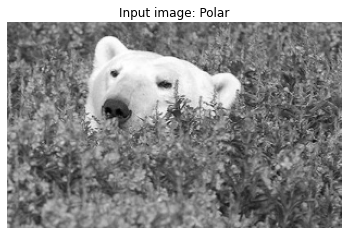

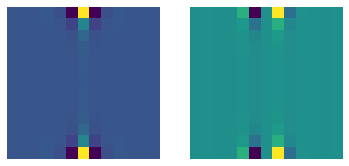

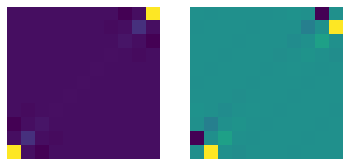

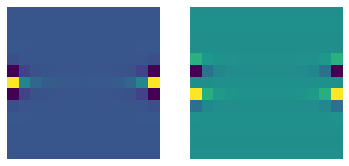

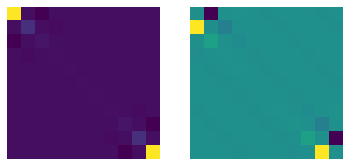

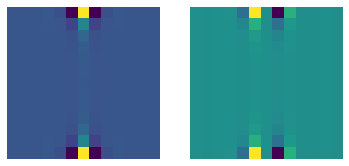

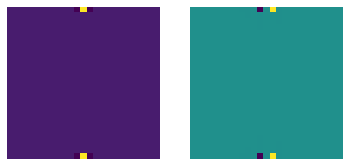

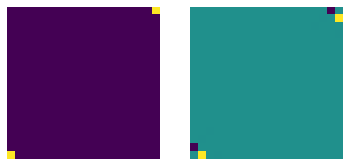

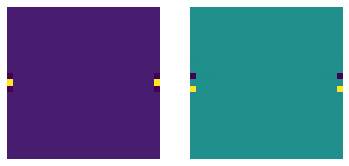

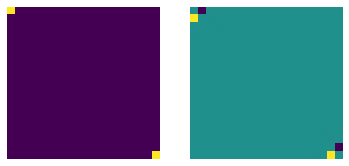

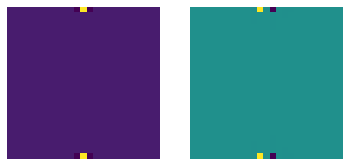

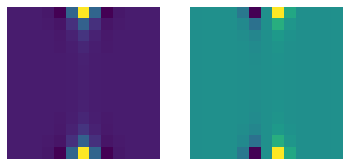

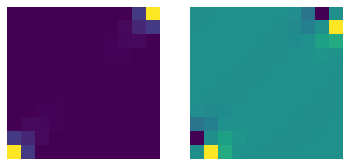

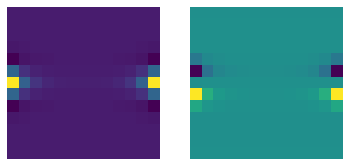

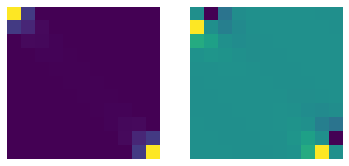

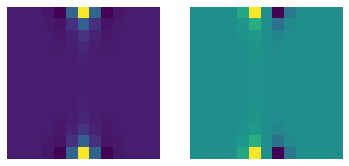

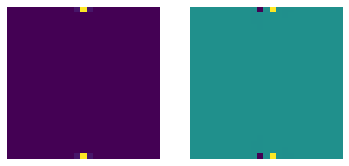

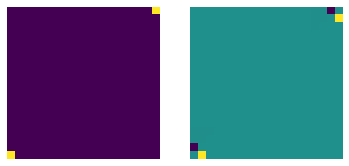

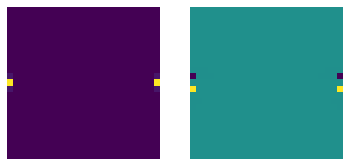

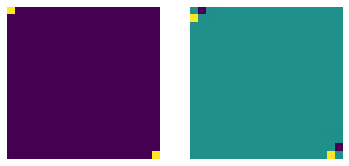

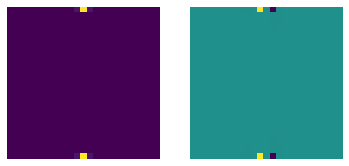

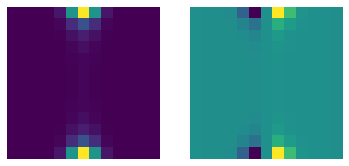

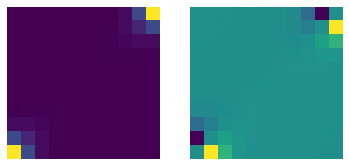

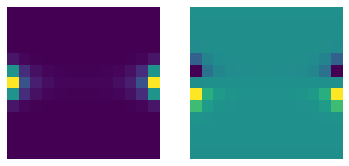

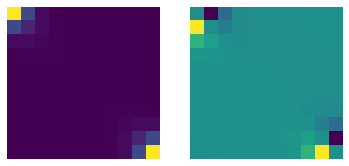

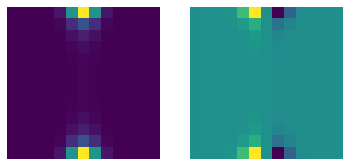

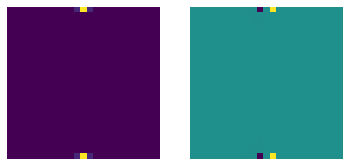

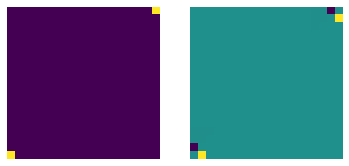

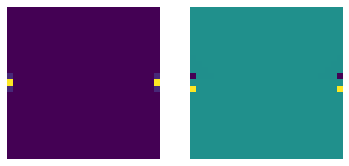

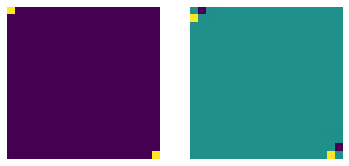

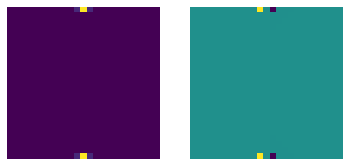

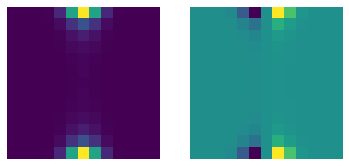

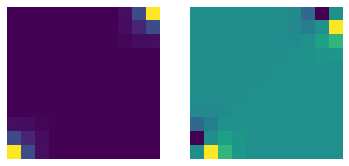

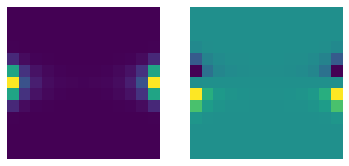

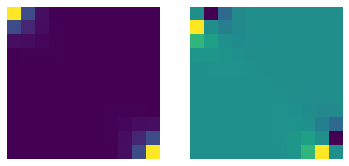

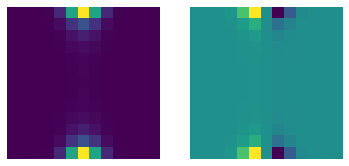

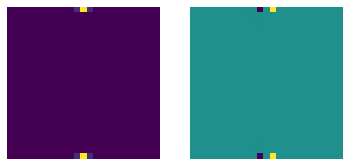

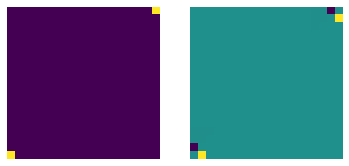

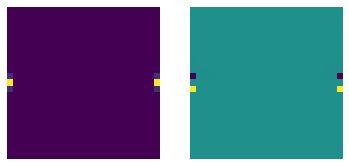

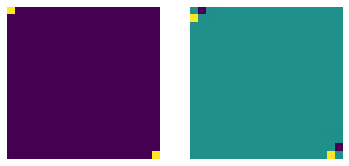

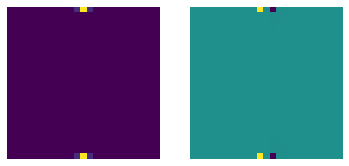

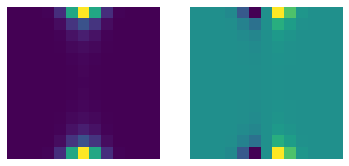

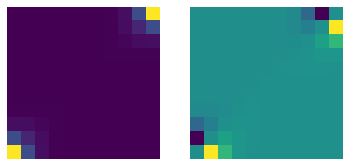

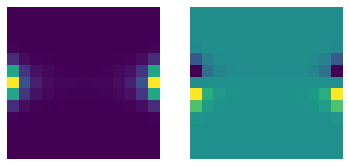

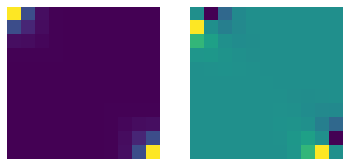

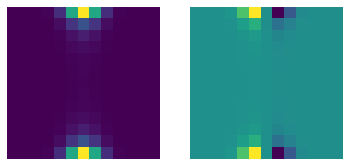

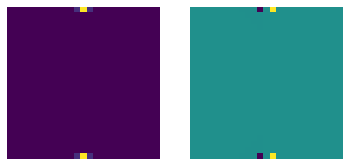

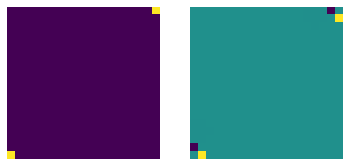

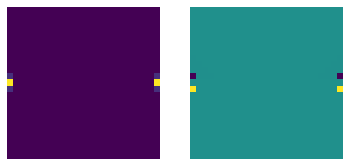

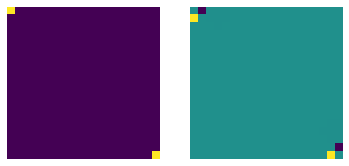

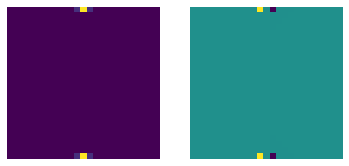

--------------------------------------
 		Details
--------------------------------------
Total number of filters       : 50
Number of scales (sigma)      : 2
Number of orientations (theta): 5
Number of carriers (lambda)   : 5
---------------------------------------
Filter bank created in 3.4578170776367188 seconds.
---------------------------------------


In [3]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import time
from sklearn.decomposition import PCA



# Hyperparameters
k        = 2      # number of clusters in k-means algorithm. By default, 
                  # we consider k to be 2 in foreground-background segmentation task.
image_id = 'Polar' # Identifier to switch between input images.
                  # Possible ids: 'Kobi',    'Polar', 'Robin-1'
                  #               'Robin-2', 'Cows', 'SciencePark'

# Misc
err_msg  = 'Image not available.'

# Control settings
visFlag       = True   #  Set to true to visualize filter responses.
smoothingFlag = True   #  Set to true to postprocess filter outputs.

# Read image : Please check that your path is correct
if image_id == 'Kobi':
  img = cv2.imread('./data/kobi.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resize_factor = 0.25
elif image_id == 'Polar':
  img = cv2.imread('./data/polar-bear-hiding.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resize_factor = 0.75
elif image_id == 'Robin-1':
  img = cv2.imread('./data/robin-1.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resize_factor = 1
elif image_id == 'Robin-2':
  img = cv2.imread('./data/robin-2.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resize_factor = 0.5
elif image_id == 'Cows':
  img = cv2.imread('./data/cows.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resize_factor = 0.5
elif image_id == 'SciencePark':
  img = cv2.imread('./data/sciencepark.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resize_factor = 0.2         
else:
  raise ValueError(err_msg)

# Image adjustments
img = cv2.resize(img, (0, 0), fx=resize_factor, fy=resize_factor)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Display image
plt.figure()
plt.title(f'Input image: {image_id}')
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

# Design array of Gabor Filters
# In this code section, you will create a Gabor Filterbank. A filterbank is
# a collection of filters with varying properties (e.g. {shape, texture}).
# A Gabor filterbank consists of Gabor filters of distinct orientations
# and scales. We will use this bank to extract texture information from the
# input image. 

numRows, numCols = img.shape

# Estimate the minimum and maximum of the wavelengths for the sinusoidal
# carriers. 
# ** This step is pretty much standard, therefore, you don't have to
#    worry about it. It is cycles in pixels. **   
lambdaMin = 4/np.sqrt(2)
lambdaMax = np.sqrt(abs(numRows)**2 + abs(numCols)**2)

# Specify the carrier wavelengths.  
# (or the central frequency of the carrier signal, which is 1/lambda)
n = np.floor(np.log2(lambdaMax/lambdaMin))
lambdas = 2**np.arange(0, (n-2)+1) * lambdaMin

# Define the set of orientations for the Gaussian envelope.
dTheta       = 2 * np.pi/8                  # \\ the step size
orientations = np.arange(0, np.pi+dTheta, dTheta)        


# Define the set of sigmas for the Gaussian envelope. Sigma here defines 
# the standard deviation, or the spread of the Gaussian. 
sigmas = np.array([1,2])

# Now you can create the filterbank. We provide you with a Python list
# called gaborFilterBank in which we will hold the filters and their
# corresponding parameters such as sigma, lambda and etc. 
# ** All you need to do is to implement createGabor(). Rest will be handled
#    by the provided code block. **
gaborFilterBank = []
tic = time.time()
for lmbda in lambdas:
    for sigma in sigmas:
        for theta in orientations:
            #print(theta)
            # Filter parameter configuration for this filter.
            psi    = 0
            gamma  = 0.5
            
            # Create a Gabor filter with the specs above. 
            # (We also record the settings in which they are created. )
            # // TODO: Implement the function createGabor() following
            #          the guidelines in the given function template.
            #          ** See createGabor.py for instructions ** //
            filter_config = {}
            filter_config["filterPairs"] = createGabor( sigma, theta, lmbda, psi, gamma )
            filter_config["sigma"]       = sigma
            filter_config["lmbda"]       = lmbda
            filter_config["theta"]       = theta
            filter_config["psi"]         = psi
            filter_config["gamma"]       = gamma
            gaborFilterBank.append(filter_config)
ctime = time.time() - tic

print('--------------------------------------\n \t\tDetails\n--------------------------------------')
print(f'Total number of filters       : {len(gaborFilterBank)}')
print(f'Number of scales (sigma)      : {len(sigmas)}')
print(f'Number of orientations (theta): {len(orientations)}')
print(f'Number of carriers (lambda)   : {len(lambdas)}')
print(f'---------------------------------------')
print(f'Filter bank created in {ctime} seconds.')
print(f'---------------------------------------')



In [4]:
generateRotationMatrix(0.2)

array([[ 0.98006658,  0.19866933],
       [-0.19866933,  0.98006658]])

In [5]:
sigma_x = sigma
sigma_y = float(sigma)/gamma
nstds = 3
xmax = max(abs(nstds*sigma_x*np.cos(theta)),abs(nstds*sigma_y*np.sin(theta)))
xmax = np.ceil(max(1,xmax))
ymax = max(abs(nstds*sigma_x*np.sin(theta)),abs(nstds*sigma_y*np.cos(theta)))
ymax = np.ceil(max(1,ymax))

# Make sure that we get square filters. 
xmax = max(xmax,ymax)
ymax = max(xmax,ymax)
xmin = -xmax 
ymin = -ymax


[x,y] = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))

    # Convert to a 2-by-N matrix where N is the number of pixels in the kernel.
XY = np.concatenate((x.reshape(1, -1), y.reshape(1, -1)), axis=0)
rotMat = generateRotationMatrix(0.2)
print(rotMat.shape)
rot_XY = np.matmul(rotMat,XY)
print(XY)
rot_XY = np.matmul(rotMat,XY)
print(rot_XY)

(2, 2)
[[-12. -11. -10. ...  10.  11.  12.]
 [-12. -12. -12. ...  12.  12.  12.]]
[[-14.1448309  -13.16476433 -12.18469775 ...  12.18469775  13.16476433
   14.1448309 ]
 [ -9.37676696  -9.5754363   -9.77410563 ...   9.77410563   9.5754363
    9.37676696]]


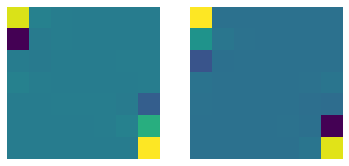

array([[[ 5.63382239e+02,  7.12059202e+02],
        [ 1.82882690e+01,  5.46388466e-01],
        [ 4.72202324e-01, -5.28618349e-01],
        [-7.49678854e-03, -5.22569578e-02],
        [-6.41770764e-03, -3.99442627e-03],
        [-1.97867401e-03,  6.44407018e-04],
        [-4.12984519e-04,  1.02098296e-03]],

       [[-4.53719034e+02,  1.58316105e+02],
        [-7.33833759e+00,  1.92909446e+01],
        [ 8.29125660e-01,  1.48899379e+00],
        [ 2.65625578e-01,  5.14002100e-02],
        [ 6.41842087e-02, -5.19491714e-02],
        [ 9.10255222e-04, -4.84420765e-02],
        [-4.11619768e-02, -3.59570913e-02]],

       [[-2.76398376e-01, -1.32287791e+02],
        [-9.28494354e+00, -7.77517350e+00],
        [-2.09910107e+00,  3.69937497e-01],
        [-3.61340900e-01,  6.24163324e-01],
        [ 1.59464378e-01,  4.41232530e-01],
        [ 5.50697705e-01,  2.02532038e-01],
        [ 1.22492301e+00, -6.99971692e-01]],

       [[ 1.79107073e+01,  6.16574523e+00],
        [ 3.17014200e+00, 

In [6]:
createGabor(1,2,3,4,1)

In [9]:
from math import pi,sqrt,exp
def  gauss1D(sigma ,kernel_size):
	if kernel_size % 2 == 0:
		raise ValueError('kernel_size must be odd, otherwise the filter will not have a center to convolve on')
	
	truncate_range = range(-int(kernel_size/2), int(kernel_size/2+1))
	X = [(1 / (sigma * sqrt(2 * pi))) * exp(-(x**2)/(2*sigma**2)) 
        for x in truncate_range]

    # normalize G to sum to 1
	G =  np.asarray(X) / sum(X)
	return G

def  gauss2D(sigma_x,sigma_y,kernel_size):
	X = gauss1D(sigma_x, kernel_size)
	Y = gauss1D(sigma_y, kernel_size)
	G = np.outer(X,Y)
	return G

	


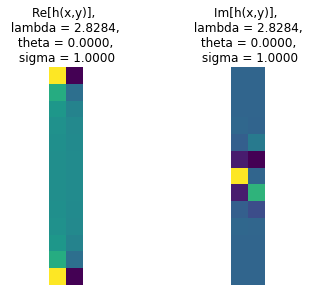

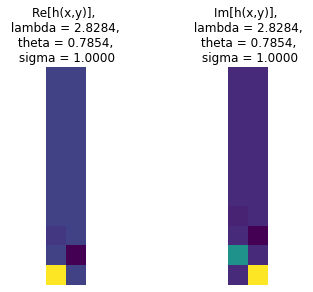

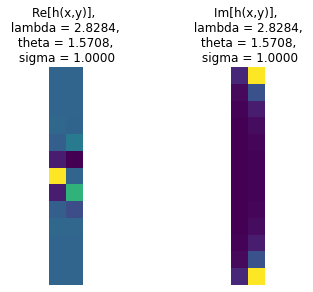

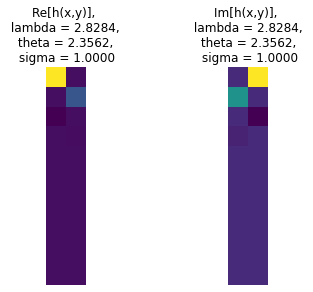

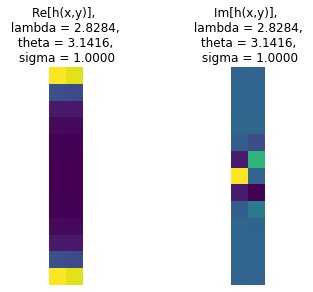

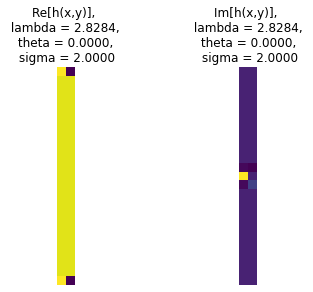

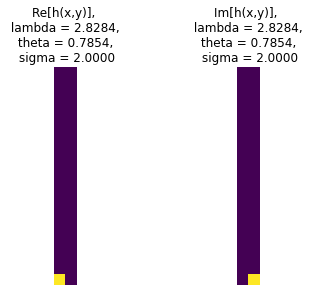

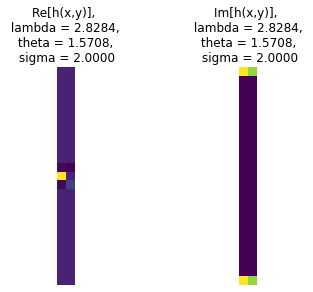

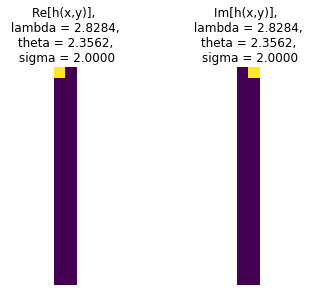

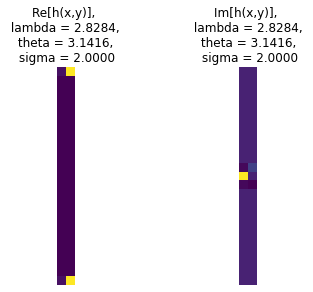

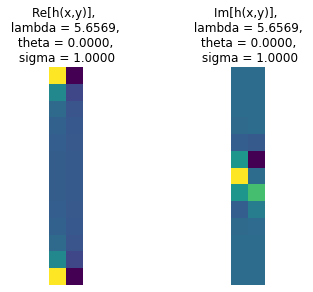

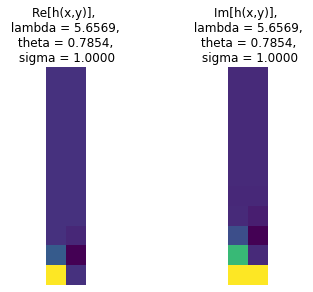

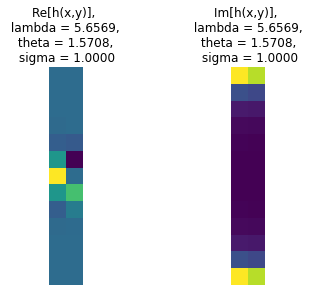

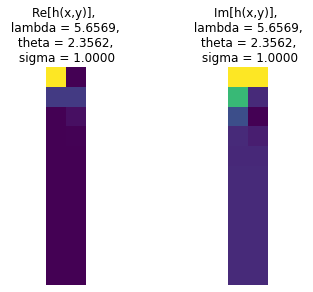

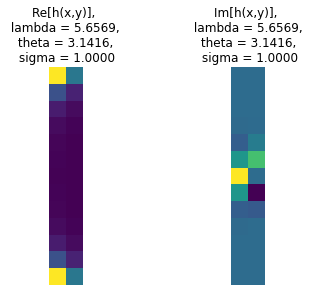

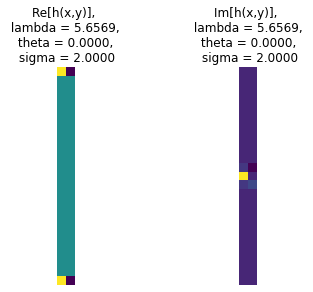

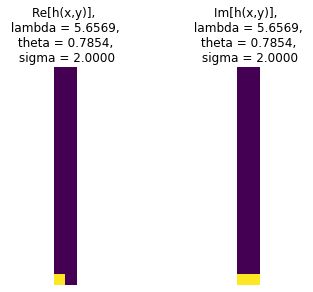

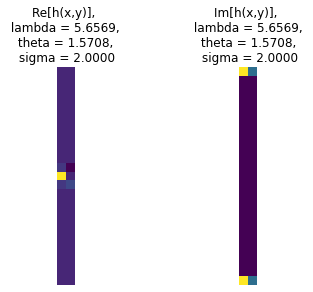

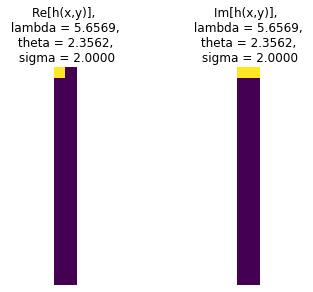

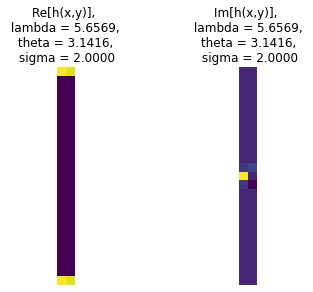

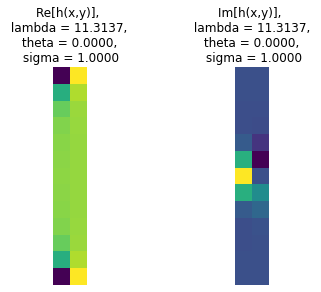

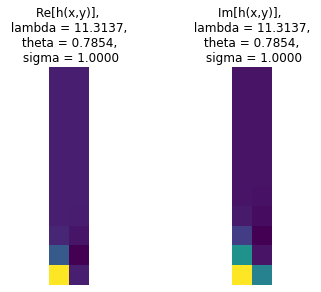

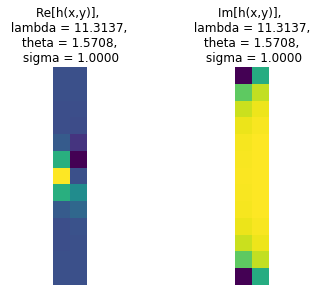

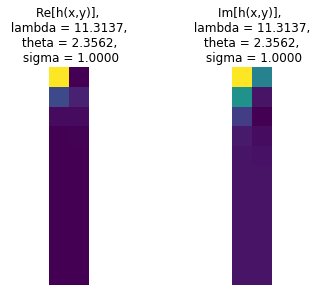

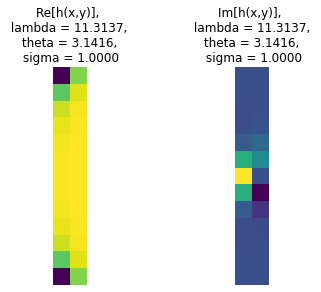

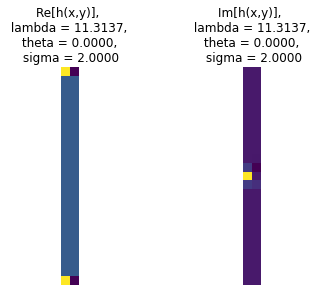

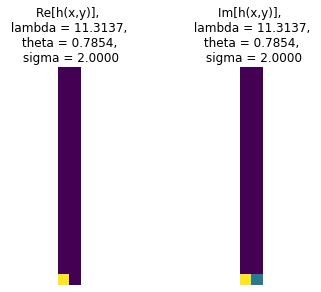

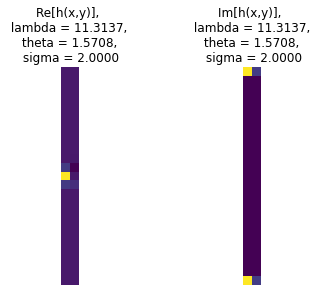

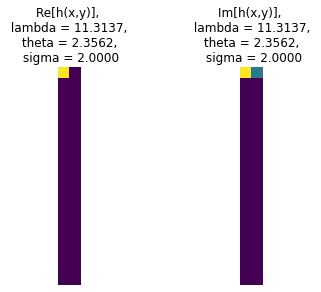

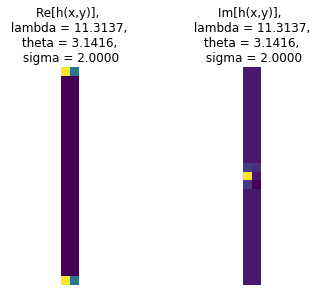

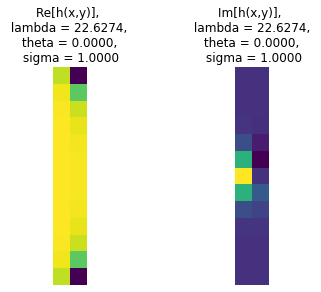

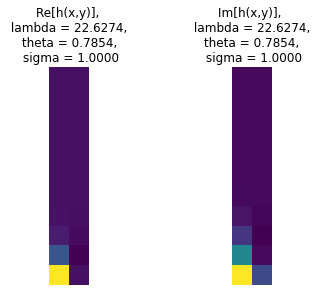

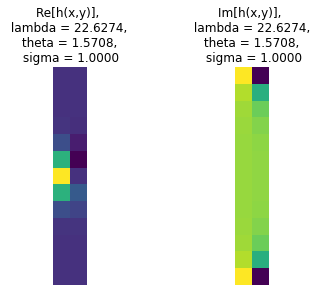

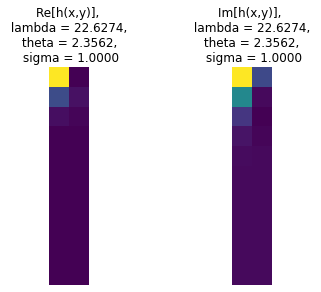

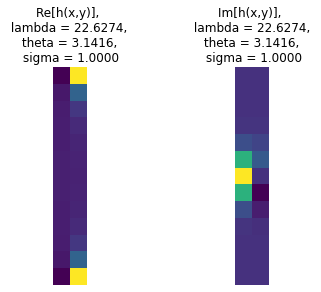

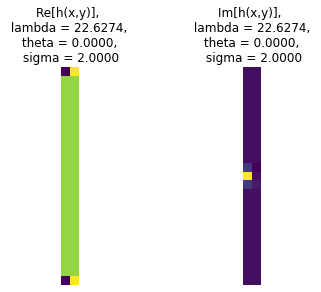

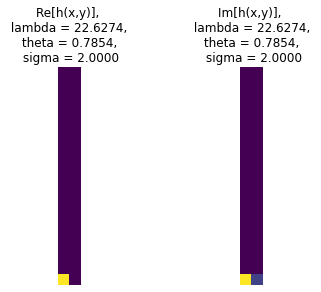

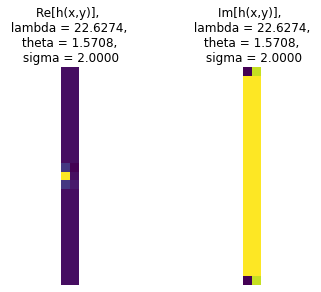

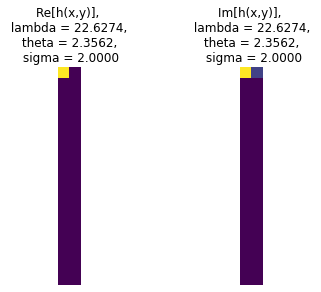

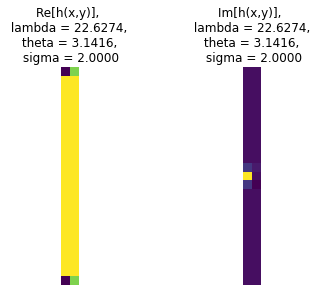

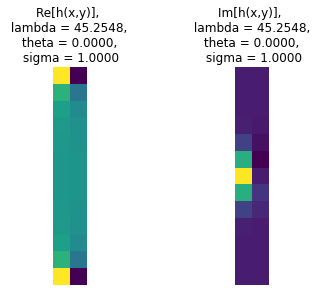

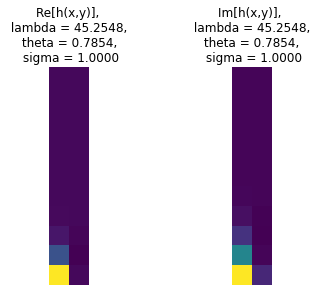

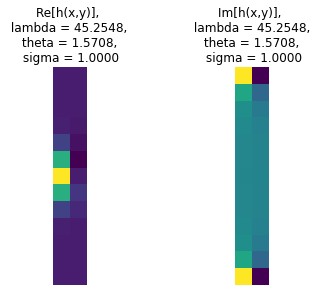

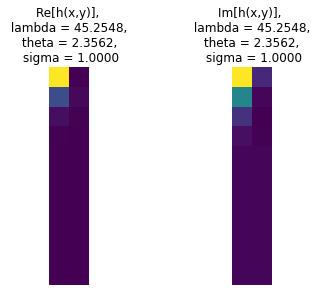

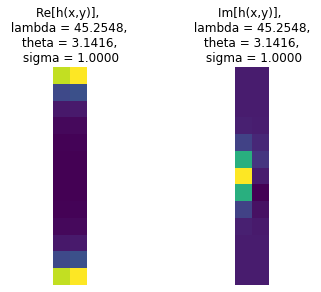

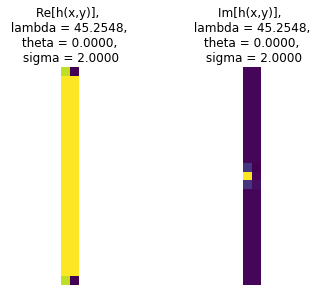

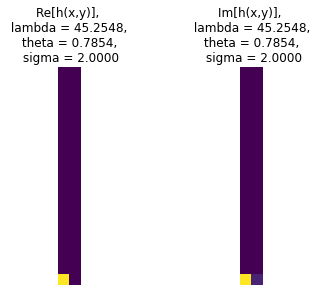

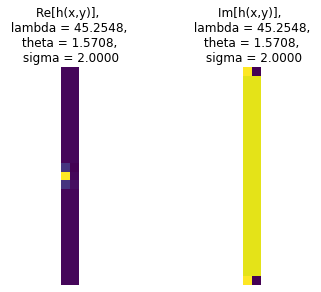

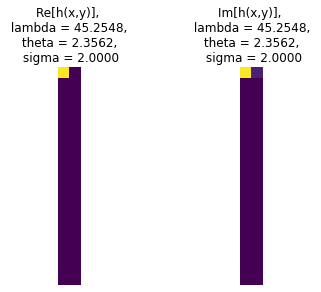

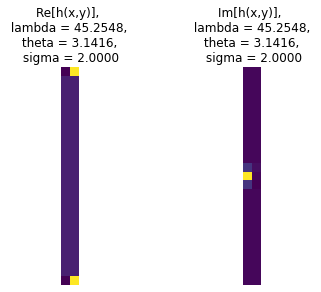

<ipython-input-10-95e571513f7e>:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


ValueError: could not broadcast input array from shape (5,5) into shape (189,308)

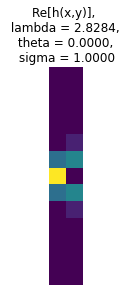

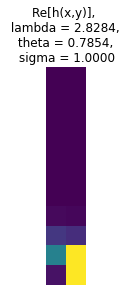

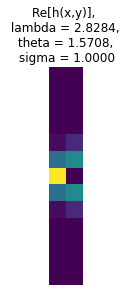

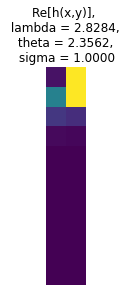

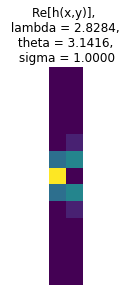

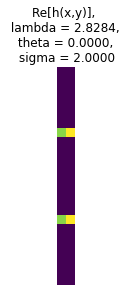

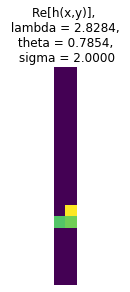

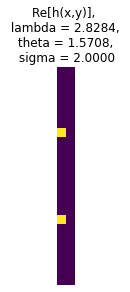

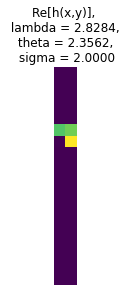

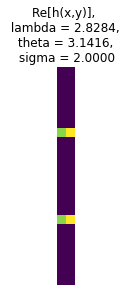

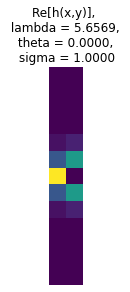

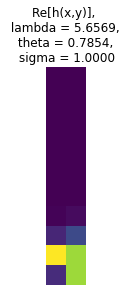

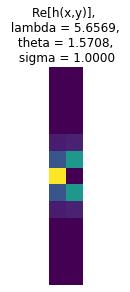

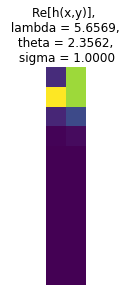

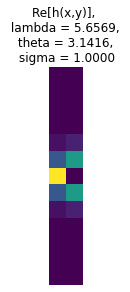

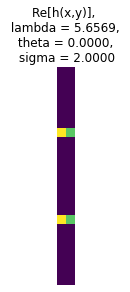

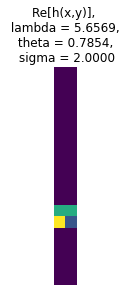

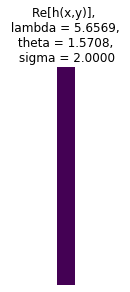

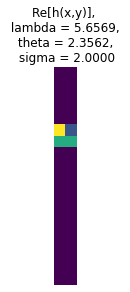

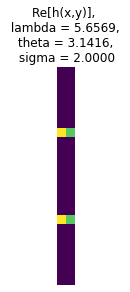

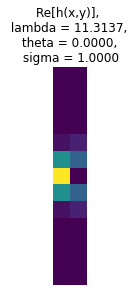

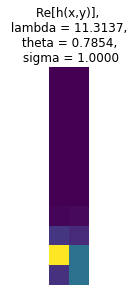

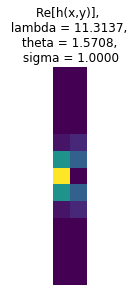

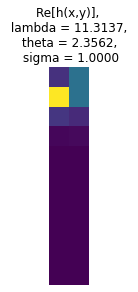

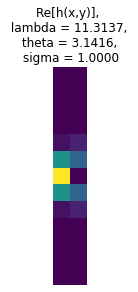

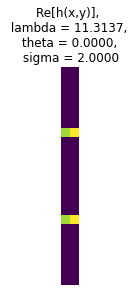

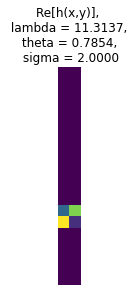

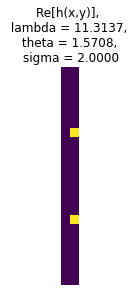

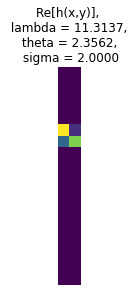

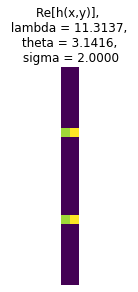

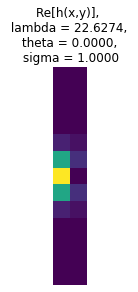

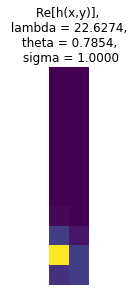

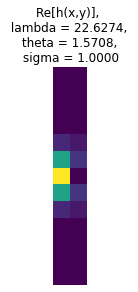

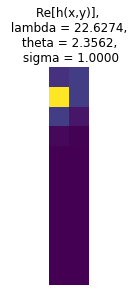

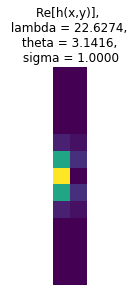

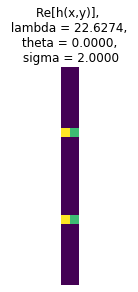

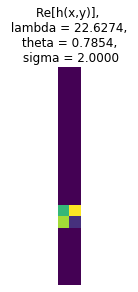

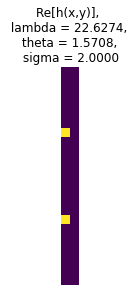

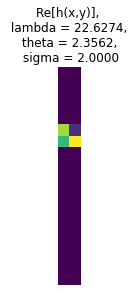

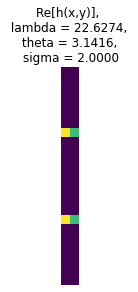

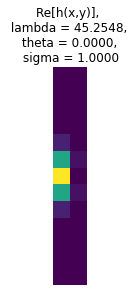

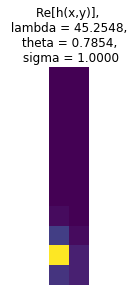

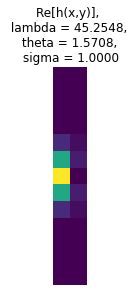

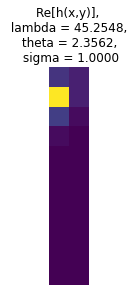

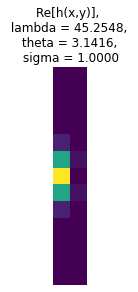

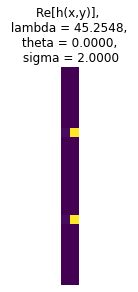

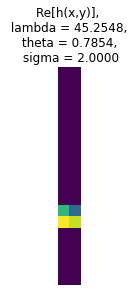

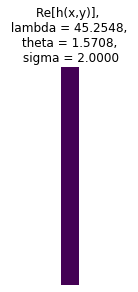

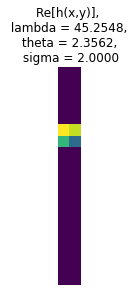

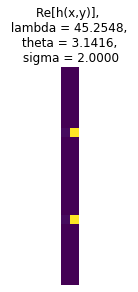

In [10]:

# Filter images using Gabor filter bank using quadrature pairs (real and imaginary parts)
# You will now filter the input image with each complex Gabor filter in 
# gaborFilterBank structure and store the output in the cell called 
# featureMaps. 
# // Hint-1: Apply both the real imaginary parts of each kernel 
#            separately in the spatial domain (i.e. over the image). //
# // Hint-2: Assign each output (i.e. real and imaginary parts) in
#            variables called real_out and imag_out. //
# // Hint-3: Use built-in cv2 function, filter2D, to convolve the filter
#            with the input image. Check the options for padding. Find 
#            the one that works well. You might want to
#            explain what works better and why shortly in the report.
featureMaps = []

for gaborFilter in gaborFilterBank:
    #print(gaborFilter)
    # gaborFilter["filterPairs"] has two elements. One is related to the real part 
    # of the Gabor Filter and the other one is the imagineray part.
    real_out = gaborFilter["filterPairs"][:,0]  # \\TODO: filter the grayscale input with real part of the Gabor
    imag_out = gaborFilter["filterPairs"][1,:]  # \\TODO: filter the grayscale input with imaginary part of the Gabor
    #print(real_out)
    #print(imag_out)
    featureMaps.append(np.stack((real_out, imag_out), 2))
    
    # Visualize the filter responses if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(real_out)    # Real
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(imag_out)    # Real
        title = "Im[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")
        plt.show()

# Compute the magnitude
# Now, you will compute the magnitude of the output responses.
# \\ Hint: (real_part^2 + imaginary_part^2)^(1/2) \\
featureMags = []
for i, fm in enumerate(featureMaps):
    real_part = fm[...,0]
    imag_part = fm[...,1]
    mag =  (real_part**2+imag_part**2)**(1/2) # \\TODO: Compute the magnitude here
    featureMags.append(mag)
    
    # Visualize the magnitude response if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mag.astype(np.uint8))    # visualize magnitude
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilterBank[i]["lmbda"], 
                                                                                                 gaborFilterBank[i]["theta"], 
                                                                                                 gaborFilterBank[i]["sigma"])
        ax.set_title(title)
        ax.axis("off")

# Prepare and Preprocess features 
# You can think of each filter response as a sort of feature representation
# for the pixels. Now that you have numFilters = |gaborFilterBank| filters, 
# we can represent each pixel by this many features. 
# \\ Q: What kind of features do you think gabor filters might correspond to? 

# You will now implement a smoothing operation over the magnitude images in
# featureMags. 
# \\ Hint: For each i in [1, length(featureMags)], smooth featureMags{i}
#          using an appropriate first order Gaussian kernel.
# \\ Hint: cv2 filter2D function is helpful here.   
features = np.zeros(shape=(numRows, numCols, len(featureMags)))
if smoothingFlag:
    # \\TODO:
    for i in [1,len(featureMags)-1]:
        #print(featureMags[i])
        smoothed = gauss2D(gaborFilterBank[i]["sigma"],gaborFilterBank[i]["sigma"],5)
        
        features[:,:,i] = smoothed
        # i)  filter the magnitude response with appropriate Gaussian kernels
        # ii) insert the smoothed image into features[:,:,j]
    #END_FOR
else:
    # Don't smooth but just insert magnitude images into the matrix
    # called features.
    for i, fmag in enumerate(featureMags):
        features[:,:,i] = fmag


# Reshape the filter outputs (i.e. tensor called features) of size 
# [numRows, numCols, numFilters] into a matrix of size [numRows*numCols, numFilters]
# This will constitute our data matrix which represents each pixel in the 
# input image with numFilters features.  
features = np.reshape(features, newshape=(numRows * numCols, -1))


# Standardize features. 
# \\ Hint: see http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing for more information.

features = None  # \\ TODO: i)  Implement standardization on matrix called features.
                 #          ii) Return the standardized data matrix.


# (Optional) Visualize the saliency map using the first principal component 
# of the features matrix. It will be useful to diagnose possible problems 
# with the pipeline and filterbank.

#